In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import spatialize.gs.esi.aggfunction as af
import spatialize.gs.esi.lossfunction as lf
from spatialize import logging
from spatialize.gs.esi import esi_griddata

In [5]:
#logging.log.setLevel("DEBUG")


def func(x, y):  # a kind of "cubic" function
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y ** 2) ** 2


grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:, 0], points[:, 1])

<Axes: xlabel='X'>

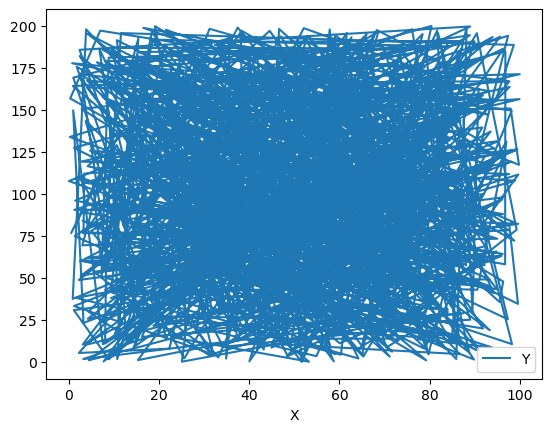

In [16]:
ds_points = pd.DataFrame({"X": points[:,1] * 100, "Y": points[:, 0] * 200})
ds_points.("X","Y")

In [3]:
result = esi_griddata(points, values, (grid_x, grid_y),
                      local_interpolator="idw",
                      p_process="mondrian",
                      data_cond=False,
                      exponent=1.0,
                      n_partitions=500, alpha=0.985,
                      agg_function=af.mean
                      )

In [4]:
res=np.ma.array(result.esi_samples(), fill_value=0, mask=np.isnan(result.esi_samples())).filled()

In [5]:
grid_cmap, prec_cmap = 'coolwarm', 'bwr'

fig = plt.figure(dpi=150)
gs = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.47)
(ax1, ax2) = gs.subplots()
ax1, ax2, ax3, ax4 = ax1[0], ax1[1], ax2[0], ax2[1]

dirichlet_weighted_average = af.WeightedAverage()
est_1 = result.re_estimate(dirichlet_weighted_average) 

ax1.imshow(est_1.T, extent=(0, 1, 0, 1), origin='lower', cmap=grid_cmap)
ax1.set_title("est_1")

op_error = pf.OperationalErrorPrecision(np.abs(np.nanmin(result.esi_samples()) - np.nanmax(result.esi_samples())))

result.precision(op_error)
result.plot_precision(ax=ax3, cmap=prec_cmap)
ax3.set_title('op error est_1')
ax3.plot(points[:, 0], points[:, 1], 'y.', ms=0.5)

# second estimation
dirichlet_weighted_average = af.WeightedAverage(normalize=True)
est_2 = result.re_estimate(dirichlet_weighted_average)

ax2.imshow(est_2.T, extent=(0, 1, 0, 1), origin='lower', cmap=grid_cmap)
ax2.set_title("est_2")

op_error = pf.OperationalErrorPrecision(np.abs(np.nanmin(result.esi_samples()) - np.nanmax(result.esi_samples())))

result.precision(op_error)
result.plot_precision(ax=ax4, cmap=prec_cmap)
ax4.set_title('op error est_2')
ax4.plot(points[:, 0], points[:, 1], 'y.', ms=0.5)

plt.show()

In [4]:
precision = result.precision_cube(pf.mse_bilateral)
reshaped_precision = precision.reshape(result.esi_samples().shape)
prec_def = np.ma.array(reshaped_precision, fill_value=0, mask=np.isnan(reshaped_precision)).filled()

In [5]:
bill = af.Bilateral_Filter(prec_def)

In [7]:
plt.imshow(bill.T)

In [2]:
!pip install gstools

  Obtaining dependency information for gstools from https://files.pythonhosted.org/packages/65/62/6baef59245f0903809e4df4610743a9a3872fb226b7d15076e336181434a/gstools-1.6.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for emcee>=3.0.0 from https://files.pythonhosted.org/packages/f9/ef/2196b9bf88ffa1bde45853c72df021fbd07a8fa91a0f59a22d14a050dc04/emcee-3.1.6-py2.py3-none-any.whl.metadata
  Obtaining dependency information for hankel>=1.0.0 from https://files.pythonhosted.org/packages/07/a7/81c1fd58eb86c34c3c9613414f98080f8b5aaf575c7d7b463e59635e0631/hankel-1.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for meshio>=5.1.0 from https://files.pythonhosted.org/packages/89/5f/39cbadc320cd78f4834b0a9f7a2fa3c980dca942bf193f315837eacb8870/meshio-5.3.5-py3-none-any.whl.metadata
  Obtaining dependency information for pyevtk>=1.1.1 from https://files.pythonhosted.org/packages/06/da/d57b07c565cc5f8705da436cfcc44754343416c1187d83f04d5443d5cc1a/pyevt